# replicate the sine model to check if we can deploy the model onto the MCU

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset

import numpy as np
import matplotlib.pyplot as plt
import math

### check if mps support is available -metal performance shaders

In [2]:
torch.backends.mps.is_available()

True

In [3]:
torch.backends.mps.is_built()

True

In [4]:
# we can use it by setting the mps device
mps = torch.device("mps")
cpu = torch.device("cpu")

## create data 

In [ ]:
SAMPLES = 1000
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

In [ ]:
# generate random numbers
x_values = np.random.uniform(low=0, high=2*math.pi, size=SAMPLES)

# shuffle the values
np.random.shuffle(x_values)

# calculate corresponding y values
y_values = np.sin(x_values)
plt.plot(x_values, y_values, 'b.')
plt.show()

In [ ]:
# add noise
y_values += 0.1 * np.random.randn(y_values.shape[0])

plt.plot(x_values, y_values, 'b.')
plt.show()

In [ ]:
TRAIN_SPLIT = int(0.6 * SAMPLES)
TEST_SPLIT = int(0.2 * SAMPLES + TRAIN_SPLIT)

x_train, x_validate, x_test = np.split(x_values, [TRAIN_SPLIT, TEST_SPLIT])
y_train, y_validate, y_test = np.split(y_values, [TRAIN_SPLIT, TEST_SPLIT])

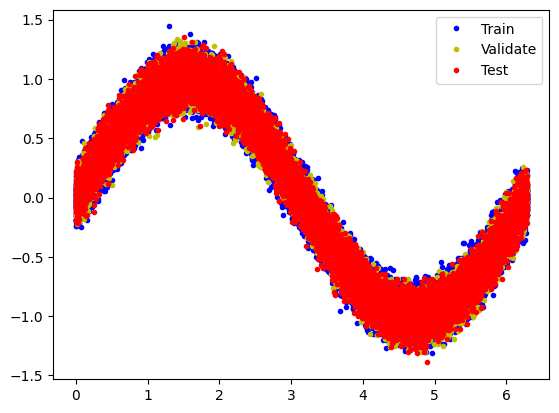

In [19]:
# Plot the data in each partition in different colors:
plt.plot(x_train, y_train, 'b.', label="Train")
plt.plot(x_validate, y_validate, 'y.', label="Validate")
plt.plot(x_test, y_test, 'r.', label="Test")
plt.legend()
plt.show()

# model

In [35]:
def train_one_epoch(model, opti, crit, device, train_data):
    
    # send model to desired device
    model.to(device)

    epoch_train_loss = list()

    for x_train, y_train in train_data:
        x_train = torch.unsqueeze(torch.tensor(x_train), dim=0).float().to(device)
        y_train = torch.unsqueeze(torch.tensor(y_train), dim=0).float().to(device)

        # make prediction
        output = model(x_train)
        # compute loss
        loss = crit(input=output.to(device), target=y_train)
        # zero out gradients
        opti.zero_grad()
        # backward pass
        loss.backward()       
        # optimization step
        opti.step()

        epoch_train_loss.append(loss.detach().cpu().numpy())

    return model, np.average(epoch_train_loss)

In [36]:
# shape should resemble the one used in the tensorflow tutorial

class Mlp(nn.Module):
    def __init__(self):
        super(Mlp, self).__init__()
        # input layer
        self.fc1 = nn.Linear(1, 16)
        # hidden layer
        self.fc2 = nn.Linear(16, 16)
        # output layer, no activation
        self.fc3 = nn.Linear(16, 1)
    
    def forward(self, x):
        # forward loop to propagate through the network
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [37]:
params = list(mlp_3.parameters())
print(len(params))
print(params[0].size())

6
torch.Size([16, 1])


In [38]:
def validate(model, val_data, device):
    val_loss = list()

    for x_val, y_val in val_data:
        x_val = torch.unsqueeze(torch.tensor(x_val), dim=0).float().to(device)
        y_val = torch.unsqueeze(torch.tensor(y_val), dim=0).float().to(device)

        assert x_val, y_val
        #prediction
        output = model(x_val)
        # compute loss
        loss = criterion(output, y_val)
        assert loss

        val_loss.append(loss.detach().cpu().numpy())
    
    return np.average(val_loss)

## training on mps

In [39]:
%%time

EPOCHS = 100
LR = 0.001


criterion = nn.MSELoss()

mlp_3 = Mlp()

optimizer = torch.optim.RMSprop(mlp_3.parameters(), lr=LR)

train_loss = list()
val_loss = list()

for epoch in range(EPOCHS):
    # training step
    mlp_3.train()
    
    mlp_3, t_loss_epoch = train_one_epoch(mlp_3, optimizer, criterion, mps, zip(x_train, y_train))
    train_loss.append(t_loss_epoch)
    
    # validation step
    mlp_3.eval()
    
    v_loss_epoch = validate(mlp_3, zip(x_validate, y_validate), mps)
    val_loss.append(v_loss_epoch)
    
    print(f"EPOCH {epoch+1}: Training loss is {t_loss_epoch} - Validation loss is {v_loss_epoch}")

EPOCH 1: Training loss is 0.28552600741386414 - Validation loss is 0.19705764949321747
EPOCH 2: Training loss is 0.163008913397789 - Validation loss is 0.17375387251377106
EPOCH 3: Training loss is 0.14900781214237213 - Validation loss is 0.1663668006658554
EPOCH 4: Training loss is 0.1419677585363388 - Validation loss is 0.15895122289657593
EPOCH 5: Training loss is 0.13511431217193604 - Validation loss is 0.14986445009708405
EPOCH 6: Training loss is 0.12740355730056763 - Validation loss is 0.13986916840076447
EPOCH 7: Training loss is 0.1119975671172142 - Validation loss is 0.11061389744281769
EPOCH 8: Training loss is 0.09130546450614929 - Validation loss is 0.09145423024892807
EPOCH 9: Training loss is 0.07463318854570389 - Validation loss is 0.06901206821203232
EPOCH 10: Training loss is 0.05886803939938545 - Validation loss is 0.05216281861066818
EPOCH 11: Training loss is 0.0440874807536602 - Validation loss is 0.03696442022919655
EPOCH 12: Training loss is 0.03447756543755531 

EPOCH 93: Training loss is 0.01238037459552288 - Validation loss is 0.009924901649355888
EPOCH 94: Training loss is 0.012356510385870934 - Validation loss is 0.009868580847978592
EPOCH 95: Training loss is 0.012339475564658642 - Validation loss is 0.009850278496742249
EPOCH 96: Training loss is 0.012328602373600006 - Validation loss is 0.009839695878326893
EPOCH 97: Training loss is 0.01233904529362917 - Validation loss is 0.009835968725383282
EPOCH 98: Training loss is 0.012305043637752533 - Validation loss is 0.009812155738472939
EPOCH 99: Training loss is 0.012288818135857582 - Validation loss is 0.00980785209685564
EPOCH 100: Training loss is 0.012284275144338608 - Validation loss is 0.009807828813791275
CPU times: user 2min 2s, sys: 22.3 s, total: 2min 24s
Wall time: 3min 3s


In [ ]:
plt.plot(range(EPOCHS),train_loss, label='Train loss')
plt.plot(range(EPOCHS), val_loss, label='Validation loss')
plt.legend()
plt.show()

## Training on cpu

In [ ]:
%%time

EPOCHS = 100
LR = 0.001


criterion = nn.MSELoss()

mlp_3 = Mlp()

optimizer = torch.optim.RMSprop(mlp_3.parameters(), lr=LR)

train_loss = list()
val_loss = list()

for epoch in range(EPOCHS):
    # training step
    mlp_3.train()
    
    mlp_3, t_loss_epoch = train_one_epoch(mlp_3, optimizer, criterion, cpu, zip(x_train, y_train))
    train_loss.append(t_loss_epoch)
    
    # validation step
    mlp_3.eval()
    
    v_loss_epoch = validate(mlp_3, zip(x_validate, y_validate), cpu)
    val_loss.append(v_loss_epoch)
    
    print(f"EPOCH {epoch+1}: Training loss is {t_loss_epoch} - Validation loss is {v_loss_epoch}")

In [ ]:
plt.plot(range(EPOCHS),train_loss, label='Train loss')
plt.plot(range(EPOCHS), val_loss, label='Validation loss')
plt.legend()
plt.show()

## implement dataset and data loader

In [30]:
SAMPLES = 1000
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

In [31]:
# generate random numbers
x_values = np.random.uniform(low=0, high=2*math.pi, size=SAMPLES)

# shuffle the values
np.random.shuffle(x_values)

# calculate corresponding y values
y_values = np.sin(x_values)

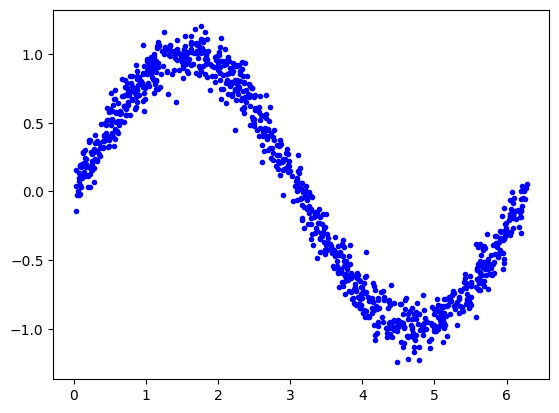

In [32]:
# add noise
y_values += 0.1 * np.random.randn(y_values.shape[0])

plt.plot(x_values, y_values, 'b.')
plt.show()

In [33]:
TRAIN_SPLIT = int(0.6 * SAMPLES)
TEST_SPLIT = int(0.2 * SAMPLES + TRAIN_SPLIT)

x_train, x_validate, x_test = np.split(x_values, [TRAIN_SPLIT, TEST_SPLIT])
y_train, y_validate, y_test = np.split(y_values, [TRAIN_SPLIT, TEST_SPLIT])

In [34]:
x_values

array([0.50412349, 5.96202367, 5.90513939, 5.02284367, 0.86406958,
       1.49053989, 5.82192175, 1.70113895, 2.49980045, 2.84276132,
       5.44163991, 6.19302445, 3.26768375, 4.37718622, 4.34128984,
       3.88381428, 3.76148219, 0.88503076, 6.05210571, 0.72154105,
       0.71297516, 0.61057792, 3.49848551, 5.25261801, 2.32577571,
       1.18200011, 0.55601479, 4.40431895, 0.71149563, 0.59340262,
       2.97491087, 3.59154845, 2.41964039, 5.70240833, 1.51960276,
       0.07636882, 2.86557222, 2.86297581, 2.26806589, 2.01093095,
       5.00011281, 4.43745078, 2.35985729, 3.89603203, 3.15842545,
       2.12129868, 3.29484124, 4.04636847, 5.40812975, 5.43814166,
       1.06495434, 3.40318814, 6.04550842, 0.12611105, 2.07909361,
       4.69649842, 1.70993833, 4.84412966, 3.96556094, 5.51331926,
       3.52660864, 1.62596258, 0.25678509, 3.31564386, 4.03400381,
       5.83944156, 1.01298322, 1.17223518, 3.66555875, 1.54818963,
       3.10260924, 5.9244764 , 0.98014248, 2.77421796, 5.96601

In [9]:
# shape should resemble the one used in the tensorflow tutorial

class Mlp(nn.Module):
    def __init__(self):
        super(Mlp, self).__init__()
        # input layer
        self.fc1 = nn.Linear(1, 16)
        # hidden layer
        self.fc2 = nn.Linear(16, 16)
        # output layer, no activation
        self.fc3 = nn.Linear(16, 1)
    
    def forward(self, x):
        # forward loop to propagate through the network
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [11]:
class SineDataset(Dataset):
    
    def __init__(self, data):
         # data is tuple of input and target
        self.x_data = data[0]
        self.y_data = data[1]
        assert len(self.x_data) == len(self.y_data)
        
    def __len__(self):
        return len(self.x_data)
    
    def __getitem__(self, idx):
        # transform data to tensor and unsqueeze to fit the dimensions
        example = torch.unsqueeze(torch.tensor(self.x_data[idx], dtype=torch.float), dim=0)
        target = torch.unsqueeze(torch.tensor(self.y_data[idx], dtype=torch.float), dim=0)
        
        return example, target

In [40]:
def train_with_loader(model, loader, opti, crit, device):
    
    model.to(device)
    
    epoch_train_loss = list()

    for _data in loader:
        # send data to device
        _inpt = _data[0].to(device)
        _trgt = _data[1].to(device)

        # make prediction
        _otp = model(_inpt)
        # compute loss
        loss = crit(_otp.to(device), _trgt).requires_grad_(True)
        # zero out gradients
        opti.zero_grad()
        # backward pass
        loss.backward()       
        # optimization step
        opti.step()

        epoch_train_loss.append(loss.detach().cpu().numpy())

    return model, np.average(epoch_train_loss)

In [48]:
def validate_with_loader(model, loader, device, crit):

    model.to(device)

    val_loss = list()

    for _data in loader:
        # send data to device
        _inpt = _data[0].to(device)
        _trgt = _data[1].to(device)

        # make prediction
        _otp = model(_inpt)
        # compute loss
        loss = crit(_otp.to(device), _trgt)

        val_loss.append(loss.detach().cpu().numpy())
    
    return np.average(val_loss)

In [49]:
EPOCHS = 100
LR = 0.001
BATCH_SIZE = 1
DEVICE = mps

criterion = nn.MSELoss()

# init model and send to desired device
mlp_3 = Mlp()

optimizer = torch.optim.RMSprop(mlp_3.parameters(), lr=LR)

# init datasets
train_ds = SineDataset((x_train, y_train))
val_ds = SineDataset((x_validate, y_validate))

# dataloaders
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

In [50]:
%%time
train_loss = list()
val_loss = list()

for epoch in range(EPOCHS):
    # training step
    mlp_3.train()
    mlp_3, t_loss_epoch = train_with_loader(mlp_3, train_loader, optimizer, criterion, DEVICE)
    train_loss.append(t_loss_epoch)
    
    # validation step
    mlp_3.eval()
    v_loss_epoch = validate_with_loader(mlp_3, val_loader, DEVICE, criterion)
    val_loss.append(v_loss_epoch)
    
    print(f"EPOCH {epoch+1}: Training loss is {t_loss_epoch} - Validation loss is {v_loss_epoch}")

EPOCH 1: Training loss is 0.23730242252349854 - Validation loss is 0.1634659618139267
EPOCH 2: Training loss is 0.1266476958990097 - Validation loss is 0.1328166425228119
EPOCH 3: Training loss is 0.10715065151453018 - Validation loss is 0.11699409782886505
EPOCH 4: Training loss is 0.09344945102930069 - Validation loss is 0.10469825565814972
EPOCH 5: Training loss is 0.08446916192770004 - Validation loss is 0.09556650370359421
EPOCH 6: Training loss is 0.07793328166007996 - Validation loss is 0.0882815346121788
EPOCH 7: Training loss is 0.07255463302135468 - Validation loss is 0.08206133544445038
EPOCH 8: Training loss is 0.06780166923999786 - Validation loss is 0.07643644511699677
EPOCH 9: Training loss is 0.06350117176771164 - Validation loss is 0.07101216167211533
EPOCH 10: Training loss is 0.05927719175815582 - Validation loss is 0.06501609832048416
EPOCH 11: Training loss is 0.05479870364069939 - Validation loss is 0.058602333068847656
EPOCH 12: Training loss is 0.050383441150188

EPOCH 93: Training loss is 0.011301886290311813 - Validation loss is 0.010486803017556667
EPOCH 94: Training loss is 0.01128257717937231 - Validation loss is 0.010509653016924858
EPOCH 95: Training loss is 0.011270162649452686 - Validation loss is 0.010491029359400272
EPOCH 96: Training loss is 0.011256197467446327 - Validation loss is 0.010444846004247665
EPOCH 97: Training loss is 0.011241620406508446 - Validation loss is 0.01044654380530119
EPOCH 98: Training loss is 0.011238791979849339 - Validation loss is 0.010438134893774986
EPOCH 99: Training loss is 0.011225324124097824 - Validation loss is 0.010420533828437328
EPOCH 100: Training loss is 0.01121168490499258 - Validation loss is 0.010430159978568554
CPU times: user 2min 1s, sys: 19.9 s, total: 2min 21s
Wall time: 2min 54s


In [ ]:
test_ds = SineDataset((x_test, y_test))
test_loader = DataLoader(test_ds, batch_size=10, shuffle=False)

test_loss = validate_with_loader(mlp_3, test_loader, DEVICE, criterion)

print(test_loss)

In [ ]:
test_ds = SineDataset((x_test, y_test))
test_loader = DataLoader(test_ds, batch_size=10, shuffle=False)

test_loss = validate_with_loader(mlp_3, test_loader, DEVICE, criterion)

print(test_loss)

In [ ]:
print(x_test[0])
print(y_test[0])

In [ ]:
mlp_3.to(mps)


In [ ]:

# before:

print(mlp_3(torch.unsqueeze(torch.tensor(x_test[0], dtype=torch.float), dim=0).to(mps)))

In [ ]:
# after:

print(mlp_3(torch.unsqueeze(torch.tensor(x_test[0], dtype=torch.float), dim=0).to(mps)))

cpu, 1, 9.35s
cpu, 30, 9.5s
cpu, 50, 9.66s
cpu, 100, 9.27s
cpu, 200, 

mps, 1, 
mps, 30, 
mps, 50,
mps, 100,
mps, 200, 